11 ulike rapporter i .xlsx 
- Inneholder tusenvis av turer(rows), ulike attributter(kolonner), 
- Interessert i 3-4 kolonner: tidspunkt, prisen, løyvenummer, (bilnummer if/A)
- Tabelloverskrift kan bestå av 1-3 linjer, den siste inneholder kolonne beskrivelse^^
- Format varierer betydelig 
- Bilnummer har formatet «xxnnnnn», f eks EL12345 eller PR54321. Løyvenummer har formatet «xxnnnnnnnnn», f eks AG4203000123, OS0303013246 eller «x-nnnnnnnn», f eks K-10030532. 

Oppgave 1 
1. Read 11 .xlsx rapports
2. Extract tidspunkt, prisen, løyvenummer, bilnummer columns from .xlsx
3. Consolidate these columns into a dataframe
Define functions for each column to clean each column
4. Format all the dates to MM/dd/yyyy hh:mm:ss tt
5. def clean_price(price): 
- Convert all data to integer and remove strings and remove ' ' 
- Use a price parser package to extract price https://github.com/oxylabs/Price-Parsing-Tutorial 
- Replace decimal separate with '.' from ',' 
6. Store dataframe in database
7. Generate total value and divide by Løyvenummer
8. Generate the excel file using the created dataframe
9. Sorter etter løyvenummer og tidspunkt i excel filen

In [25]:
import pandas as pd
import re as re
import sqlite3
import openpyxl
from IPython.display import display, Image

In [8]:
# Step 1: Read Excel Files
excel_files = ["salgs_rapport_en.xlsx", "salgs_rapport_to.xlsx",] 
dataframes = [pd.read_excel(file) for file in excel_files]

In [9]:
# Step 2: Data Extraction
relevant_columns = ["Tidspunkt", "Kundepris", "Løyve","Bilnummer"]
dataframes_filtered = [df[relevant_columns] for df in dataframes]

In [10]:
# Step 3: Data consolidation 
consolidated_dataframe = pd.concat(dataframes_filtered, ignore_index=True)
print(consolidated_dataframe)

          Tidspunkt  Kundepris         Løyve  Bilnummer
0  01.05.2023 16:10        489  AG4203000196        NaN
1  01.05.2023 16:30       1776  AG4203000009        NaN
2  01.05.2023 16:40        243  AG4203000020        NaN
3  01.05.2023 16:50        315  AG4203000071        NaN
4  02.05.2023 09:15        420  AG4203000196        NaN
5  02.05.2023 10:30        980  AG4203000009        NaN
6  03.05.2023 14:20        550  AG4203000021        NaN
7  03.05.2023 15:45        300  AG4203000078        NaN


In [11]:
# Step 4: Format Tidspunkt column
def format_times_in_dataframe(consolidated_df, Tidspunkt):
    consolidated_dataframe[Tidspunkt] = pd.to_datetime(consolidated_dataframe[Tidspunkt])
    consolidated_dataframe[Tidspunkt] = consolidated_dataframe[Tidspunkt].dt.strftime("%m/%d/%Y %H:%M:%S")
    return consolidated_df
print(consolidated_dataframe)

          Tidspunkt  Kundepris         Løyve  Bilnummer
0  01.05.2023 16:10        489  AG4203000196        NaN
1  01.05.2023 16:30       1776  AG4203000009        NaN
2  01.05.2023 16:40        243  AG4203000020        NaN
3  01.05.2023 16:50        315  AG4203000071        NaN
4  02.05.2023 09:15        420  AG4203000196        NaN
5  02.05.2023 10:30        980  AG4203000009        NaN
6  03.05.2023 14:20        550  AG4203000021        NaN
7  03.05.2023 15:45        300  AG4203000078        NaN


In [12]:
# Step 5: Use regex to format price column
def clean_price_data(consolidated_dataframe):
    def clean_price(price_str):
        # Remove any non-digit characters except commas and periods
        cleaned_price = re.sub(r'[^\d,.]', '', price_str)

        # Remove multiple commas and periods, keeping the last one as the decimal point
        cleaned_price = re.sub(r'[,.](?=.*[,.])', '', cleaned_price)

        # Replace the last comma with a period to represent the decimal point
        cleaned_price = cleaned_price.rsplit(',', 1)
        if len(cleaned_price) > 1:
            cleaned_price[-1] = '.' + cleaned_price[-1]
        cleaned_price = ''.join(cleaned_price)

        return cleaned_price

    consolidated_dataframe['Kundepris'] = consolidated_dataframe['Kundepris'].apply(clean_price)

    # Convert the column to numeric values 
    consolidated_dataframe['Kundepris'] = pd.to_numeric(consolidated_dataframe['Kundepris'], errors='coerce')

    return consolidated_dataframe
print(consolidated_dataframe)

          Tidspunkt  Kundepris         Løyve  Bilnummer
0  01.05.2023 16:10        489  AG4203000196        NaN
1  01.05.2023 16:30       1776  AG4203000009        NaN
2  01.05.2023 16:40        243  AG4203000020        NaN
3  01.05.2023 16:50        315  AG4203000071        NaN
4  02.05.2023 09:15        420  AG4203000196        NaN
5  02.05.2023 10:30        980  AG4203000009        NaN
6  03.05.2023 14:20        550  AG4203000021        NaN
7  03.05.2023 15:45        300  AG4203000078        NaN


In [47]:
# Step 6: Store the dataframe in a database 
conn = sqlite3.connect('samlet_salgsdata.db')

consolidated_dataframe.to_sql('people', conn, if_exists='replace', index=False)

conn.close()

In [23]:
# Step 7: Generate total value and divide by løyvenummer
total_kundepris = consolidated_dataframe['Kundepris'].sum()
total_løyve = consolidated_dataframe.groupby('Løyve')['Kundepris'].sum()
total_løyve_df = pd.DataFrame(total_løyve)
print(total_løyve_df)
print(total_kundepris)

              Kundepris
Løyve                  
AG4203000009       2756
AG4203000020        243
AG4203000021        550
AG4203000071        315
AG4203000078        300
AG4203000196        909
5073


In [24]:
# Step 8: Generate the excel file 
excel_file_path = "consolidated_data.xlsx"
writer = pd.ExcelWriter(excel_file_path, engine='xlsxwriter')

consolidated_dataframe.to_excel(writer, sheet_name='Samlet salgsdata InterCab', index=False)
total_løyve_df.to_excel(writer, sheet_name='Samlet salgsdata per Løyve', index=True)

# Close the Pandas Excel writer and save the file
writer.save()

print(f"Excel file '{excel_file_path}' has been created successfully.")


Excel file 'consolidated_data.xlsx' has been created successfully.


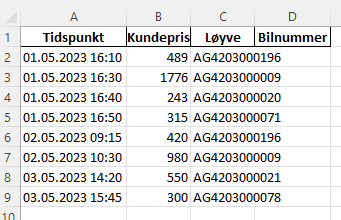

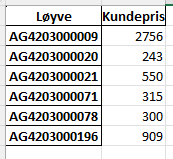

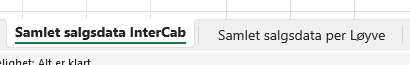

In [30]:
samlet_salgsdata = 'samlet_salgsdata.png'
display(Image(filename=samlet_salgsdata))
samlet_løyve = 'samlet_løyve.png'
display(Image(filename=samlet_løyve))
sheets = "sheets.png"
display(Image(filename=sheets))

Oppgave 2. Lage brukervennlig grensesnitt: laste opp excel filer, lagre dataene i database og generere excel output fil.
Den enkleste måten for en bruker til å kunne laste opp excel filer og få en clean excel fil i return, som også lastes opp i en database. Følgende er en eksempel på en løsning. 

- Lag en nettside ved å bruke HTML, CSS, JavaScript, Node.js, Express.js og MongoDB 

- En annen løsning til oppgave 2 som er ikke helt like omfattende er å lage hele backend i python rammeverket flask
  og kun bruke JavaScript til å lese excel filene, extracte kolonnene og gi knappen funksjonalitet. Og bruke HTML for å 
  utforme nettsiden. 

MongoDB: er en non-relation database system der data lagres i en format som ligner JSON. 

ExpressJS: er bygd på NodeJS og brukes til å gjennomføre standard HTTP metoder CRUD (Create, Read, Update, Delete). 

HTML: lag en knapp der man kan velge filer og laste de opp.   

<!-- index.html -->
<!DOCTYPE html>
<html>
  <head>
    <title>Excel File Upload</title>
  </head>
  <body>
    <h1>Upload Excel File</h1>
    <form>
      <input type="file" id="excelFile" accept=".xlsx, .xls" />
      <button type="button" onclick="uploadFile()">Upload</button>
    </form>
    <div id="status"></div>
    <a id="downloadLink" style="display: none" href="#" download
      >Download Consolidated Excel File</a
    >

    <script src="script.js"></script>
  </body>
</html>

JavaScript og NodeJS: 
1. Skap funksjonalitet til knappen. 
2. Les excel filen. 
3. Hent dataen fra excel filen og set dataen i en workbook. 
4. Clean dataen.
5. Konsolider dataen i en excel fil.
6. Lagre dataen i MongoDB database. 
7. Lag en download link for å laste ned excel filen. 
8. Implementer error handling og validering. Feil som:
    1. Feil filtype.
    2. Mangel på kolonner. 
    3. Database feilkobling
9. Deploy nettsiden 

'use strict';
async function uploadFile() {
  const fileInput = document.getElementById('excelFile');
  const file = fileInput.files[0];

  if (file) {
    try {
      const workbook = await readExcelFile(file);
      const relevantData = extractRelevantData(workbook);
      const cleanedData = cleanData(relevantData);
      const consolidatedWorkbook = createConsolidatedExcel(cleanedData);
      await saveToDatabase(cleanedData);
      downloadConsolidatedExcel(consolidatedWorkbook);
      document.getElementById('status').textContent =
        'File processed and saved to the database.';
      document.getElementById('downloadLink').style.display = 'block';
    } catch (error) {
      console.error(error);
      document.getElementById('status').textContent =
        'Error processing the file.';
    }
  } else {
    document.getElementById('status').textContent =
      'Please select an Excel file to upload.';
  }
}

function readExcelFile(file) {
  return new Promise((resolve, reject) => {
    const reader = new FileReader();
    reader.onload = (event) => {
      const data = event.target.result;
      const workbook = XLSX.read(data, { type: 'binary' });
      resolve(workbook);
    };
    reader.onerror = (error) => reject(error);
    reader.readAsBinaryString(file);
  });
}

function extractRelevantData(workbook) {
  const relevantColumns = ['Tidspunkt', 'Kundepris', 'Løyve', 'Bilnummer'];
  const dataframesFiltered = dataframes.map((df) => {
    return df.map((row) => {
      return relevantColumns.reduce((filteredRow, col) => {
        filteredRow[col] = row[col];
        return filteredRow;
      }, {});
    });
  });
}

function cleanData(data) {
  // Implement data cleaning logic
}

function createConsolidatedExcel(data) {
  // Use SheetJS or similar library to create a new workbook with the cleaned data
}

async function saveToDatabase(data) {
  // Implement database interaction logic to save the data
}

function downloadConsolidatedExcel(workbook) {
  const excelBuffer = XLSX.write(workbook, { type: 'array' });
  const blob = new Blob([excelBuffer], {
    type: 'application/vnd.openxmlformats-officedocument.spreadsheetml.sheet',
  });
  const url = URL.createObjectURL(blob);
  const downloadLink = document.getElementById('downloadLink');
  downloadLink.href = url;
}

Oppgave 3. Importfeil fra excel til db. Hvilke? Hvorfor? Hvordan kan man forebygge slike feil? Hva hvis feilene ennå oppstår?

Viktig at error handling og validering sjekker dette før dataen lastes opp i databasen:

1. Data format og type mismatch. 
2. Nullverdier og tomme cells. 
3. Dataformatet kan variere. 

For å forebygge slike feil er det viktig at man har kodet funksjonaliteten i node.js for å sjekke slike feil. I tillegg så må man passe på at funksjonene skrevet i JavaScript er fri for bugs. Det man kan teste med litt mindre data og i terminalen. Hvis feilene ennå oppstår kan man vise en feilmelding til brukeren, og si til brukeren at de må laste opp en ny feil, fordi det kan ha noen feil. (Egentlig burde ikke slike feil fortsette å oppstå). 


Oppgave 4. Hvordan utvide løsningen til å håndtere flere datafelt og andre formater. 
Slik den er designet ovenfor er nettsiden robust nok at den kan håndtere andre formater og nye kolonner. 
Det eneste som må endres i koden er i script.js så må man endre variablen
const relevantColumns = ['Tidspunkt', 'Kundepris', 'Løyve', 'Bilnummer'];
til de nye kolonnene man er ute etter. 